# EDA

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score as AUC 
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate 

from scipy import stats
import seaborn as sns
import copy

%matplotlib inline

# This may raise an exception in earlier versions of Jupyter
%config InlineBackend.figure_format = 'retina'

In this part, we do a short data exploration to see what dataset we have and whether we can find any patterns in it.



In [89]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Basic Data Stats

basic data:

In [90]:
train.shape

(188318, 132)

188K training examples, 132 columns — this dataset doesn't look so big that it can't be trained on our machine locally. 

In [91]:
print('First 20 columns:', list(train.columns[:20]))
print()
print('Last 20 columns:', list(train.columns[-20:]))

First 20 columns: ['id', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19']

Last 20 columns: ['cat112', 'cat113', 'cat114', 'cat115', 'cat116', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14', 'loss']


We see that there are probably 116 categorical columns (as their names suggest) and 14 continuous (numerical) columns.

Also, there's id and loss columns. This sums up to 132 columns total.

Next, let's see a quick statistic summary of our continuous features:

In [92]:
train.describe()

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,294135.982561,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.485506,0.498066,0.493511,0.493150,0.493138,0.495717,3037.337686
std,169336.084867,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.181660,0.185877,0.209737,0.209427,0.212777,0.222488,2904.086186
min,1.000000,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722,0.670000
25%,147748.250000,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.358970,0.364580,0.310961,0.311661,0.315758,0.294610,1204.460000
50%,294539.500000,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.461190,0.457203,0.462286,0.363547,0.407403,2115.570000
75%,440680.500000,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.566820,0.614590,0.678924,0.675759,0.689974,0.724623,3864.045000
max,587633.000000,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848,121012.250000


As we see, all continuous features have been scaled to [0,1] interval and have means around 0.5, due to some innate preprocessing on Allstate's part, presumably.


### Testing on missing values

In [93]:
pd.isnull(train).values.any()

False

Since there are **no missing values**, we do not have to do any data "cleaning" per se. We are good. 

## Continuous vs Categorical features

Another way to see the division to categorical and continuous features is to run `pd.DataFrame.info` method:

In [94]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB


In [95]:
cat_features = list(train.select_dtypes(include=['object']).columns)
print(f"Categorical: {len(cat_features)} features") #.format(len(cat_features))

Categorical: 116 features


In [96]:
cont_features = [cont for cont in list(train.select_dtypes(
                 include=['float64', 'int64']).columns) if cont not in ['loss', 'id']]
print(f"Continuous: {len(cont_features)} features")

Continuous: 14 features


In [97]:
id_col = list(train.select_dtypes(include=['int64']).columns)
print(f"A column of int64: {id_col}")

A column of int64: ['id']


## Unique values in categorical features

Let's plot a histogram visualizing the count of features with a specific amount of values.

In [98]:
cat_uniques = []
for cat in cat_features:
    cat_uniques.append(len(train[cat].unique()))
    
uniq_values_in_categories = pd.DataFrame.from_dict(dict([('cat_name', cat_features), ('unique_values', cat_uniques)]))

In [99]:
uniq_values_in_categories.head()

,cat_name,unique_values
0,cat1,2
1,cat2,2
2,cat3,2
3,cat4,2
4,cat5,2


In [100]:
# Another option is to use Series.value_counts() method, but its
# output is not that nice

uniq_values = uniq_values_in_categories.groupby('unique_values').count()
uniq_values = uniq_values.rename(columns={'cat_name': 'categories'})
uniq_values.sort_values(by='categories', inplace=True, ascending=False)
uniq_values.reset_index(inplace=True)
print(uniq_values)

    unique_values  categories
0               2          72
1               4          12
2               3           4
3               7           4
4               5           3
5               8           3
6              20           2
7              19           2
8              17           2
9              16           2
10             15           1
11             13           1
12             11           1
13              9           1
14             23           1
15             51           1
16             61           1
17             84           1
18            131           1
19            326           1


As we see, most of the categorical features are binary

## Target Feature

First, we just plot the target:

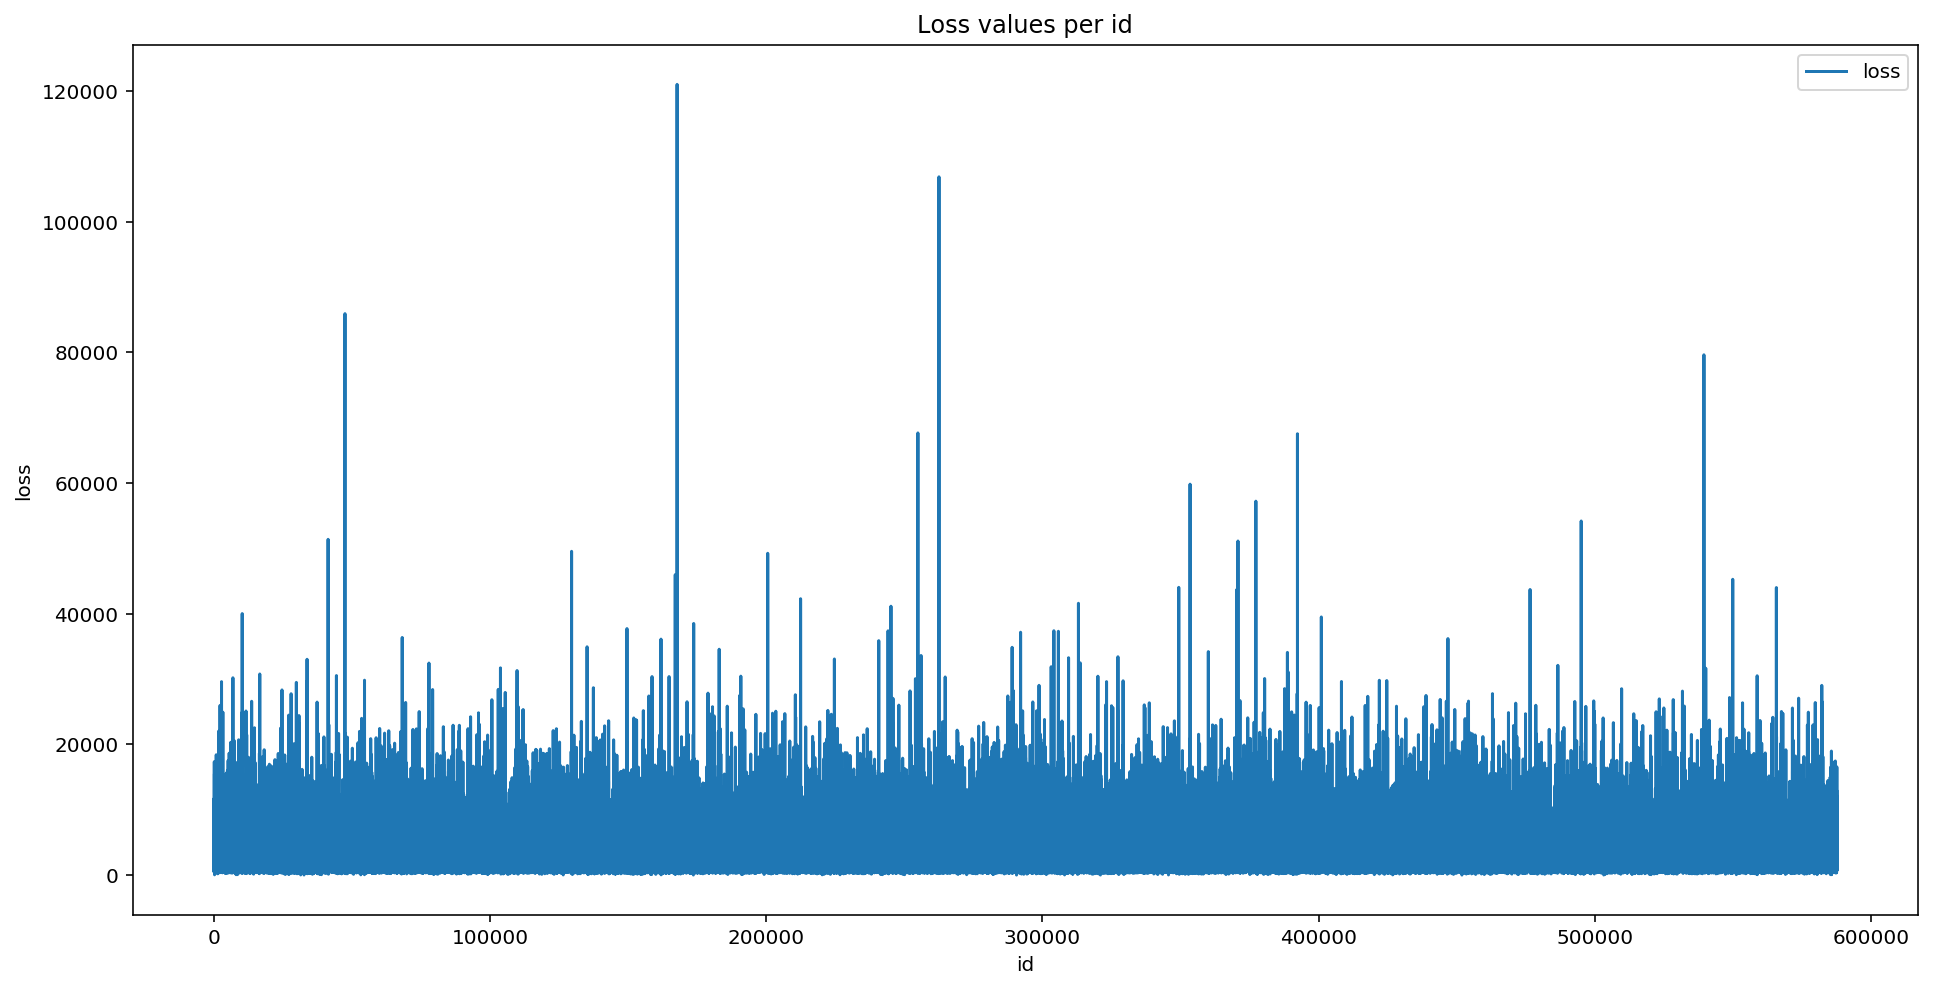

In [101]:
plt.figure(figsize=(16,8))
plt.plot(train['id'], train['loss'])
plt.title('Loss values per id')
plt.xlabel('id')
plt.ylabel('loss')
plt.legend()
plt.show()

There are several distinctive peaks in the loss values representing severe accidents. Such data distribution makes this feature very skewed and can result in suboptimal performance of the regressor.

Basically, [skewness](https://en.wikipedia.org/wiki/Skewness) measures the asymmetry of the probability distribution of a real-valued random variable about its mean. Let's calculate the skewness of `loss`:

In [102]:
stats.mstats.skew(train['loss']).data

array(3.79492815)

Yes, the data is skewed. We can measure the skewness with `stats.mstats.skew`:

When we apply `np.log` to this vector, we get better results:

In [103]:
stats.mstats.skew(np.log(train['loss'])).data

array(0.0929738)

To make sure our analysis is correct, we can plot a histogram of the loss. We also log-transform the target and plot its updated histogram.

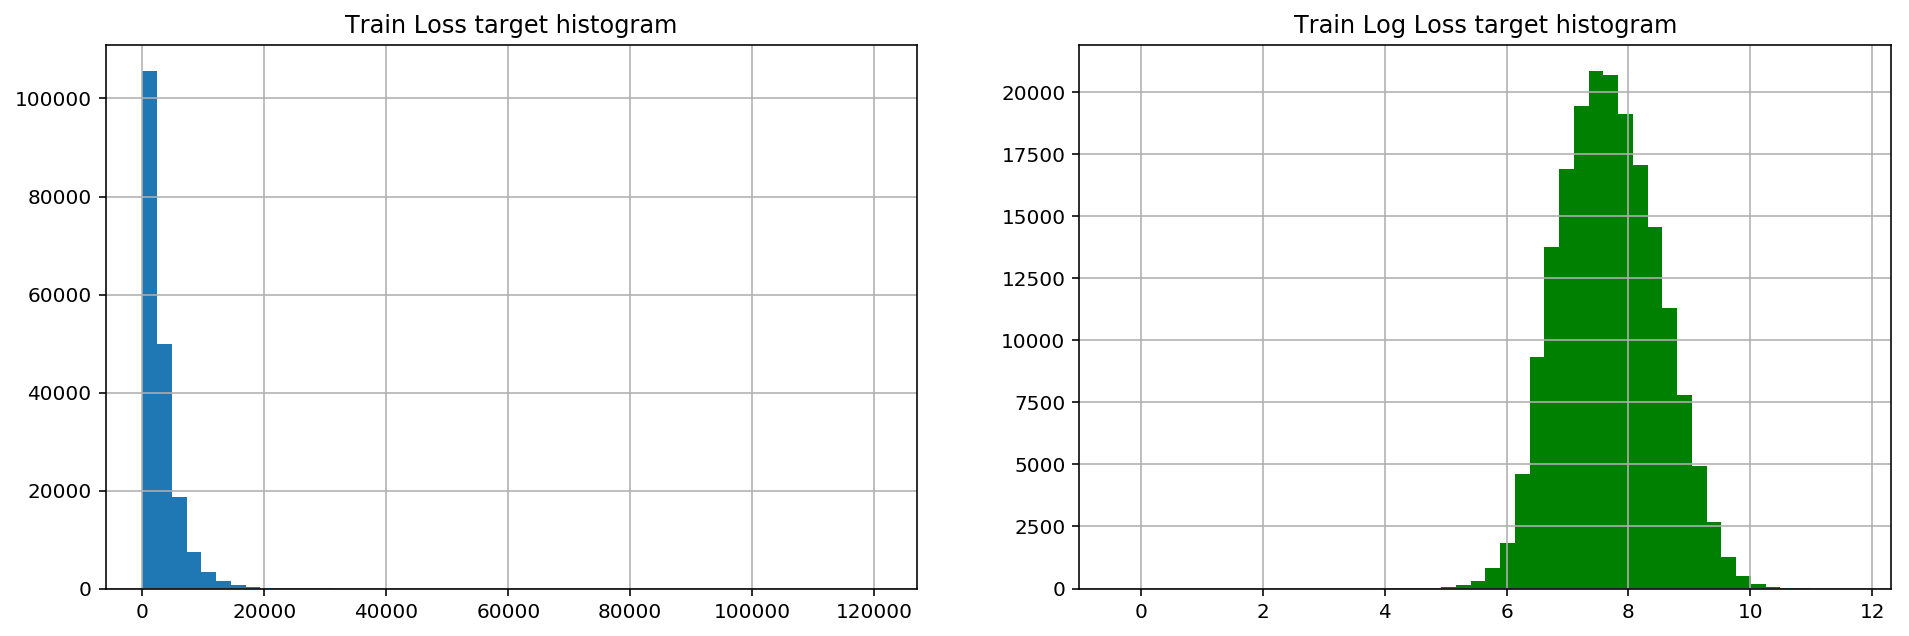

In [104]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,5)
ax1.hist(train['loss'], bins=50)
ax1.set_title('Train Loss target histogram')
ax1.grid(True)
ax2.hist(np.log(train['loss']), bins=50, color='g')
ax2.set_title('Train Log Loss target histogram')
ax2.grid(True)
plt.show()

## Continuous features

One thing we can do is to plot histogram of the numerical features and analyze their distributions:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1e185278>,
      dtype=object)

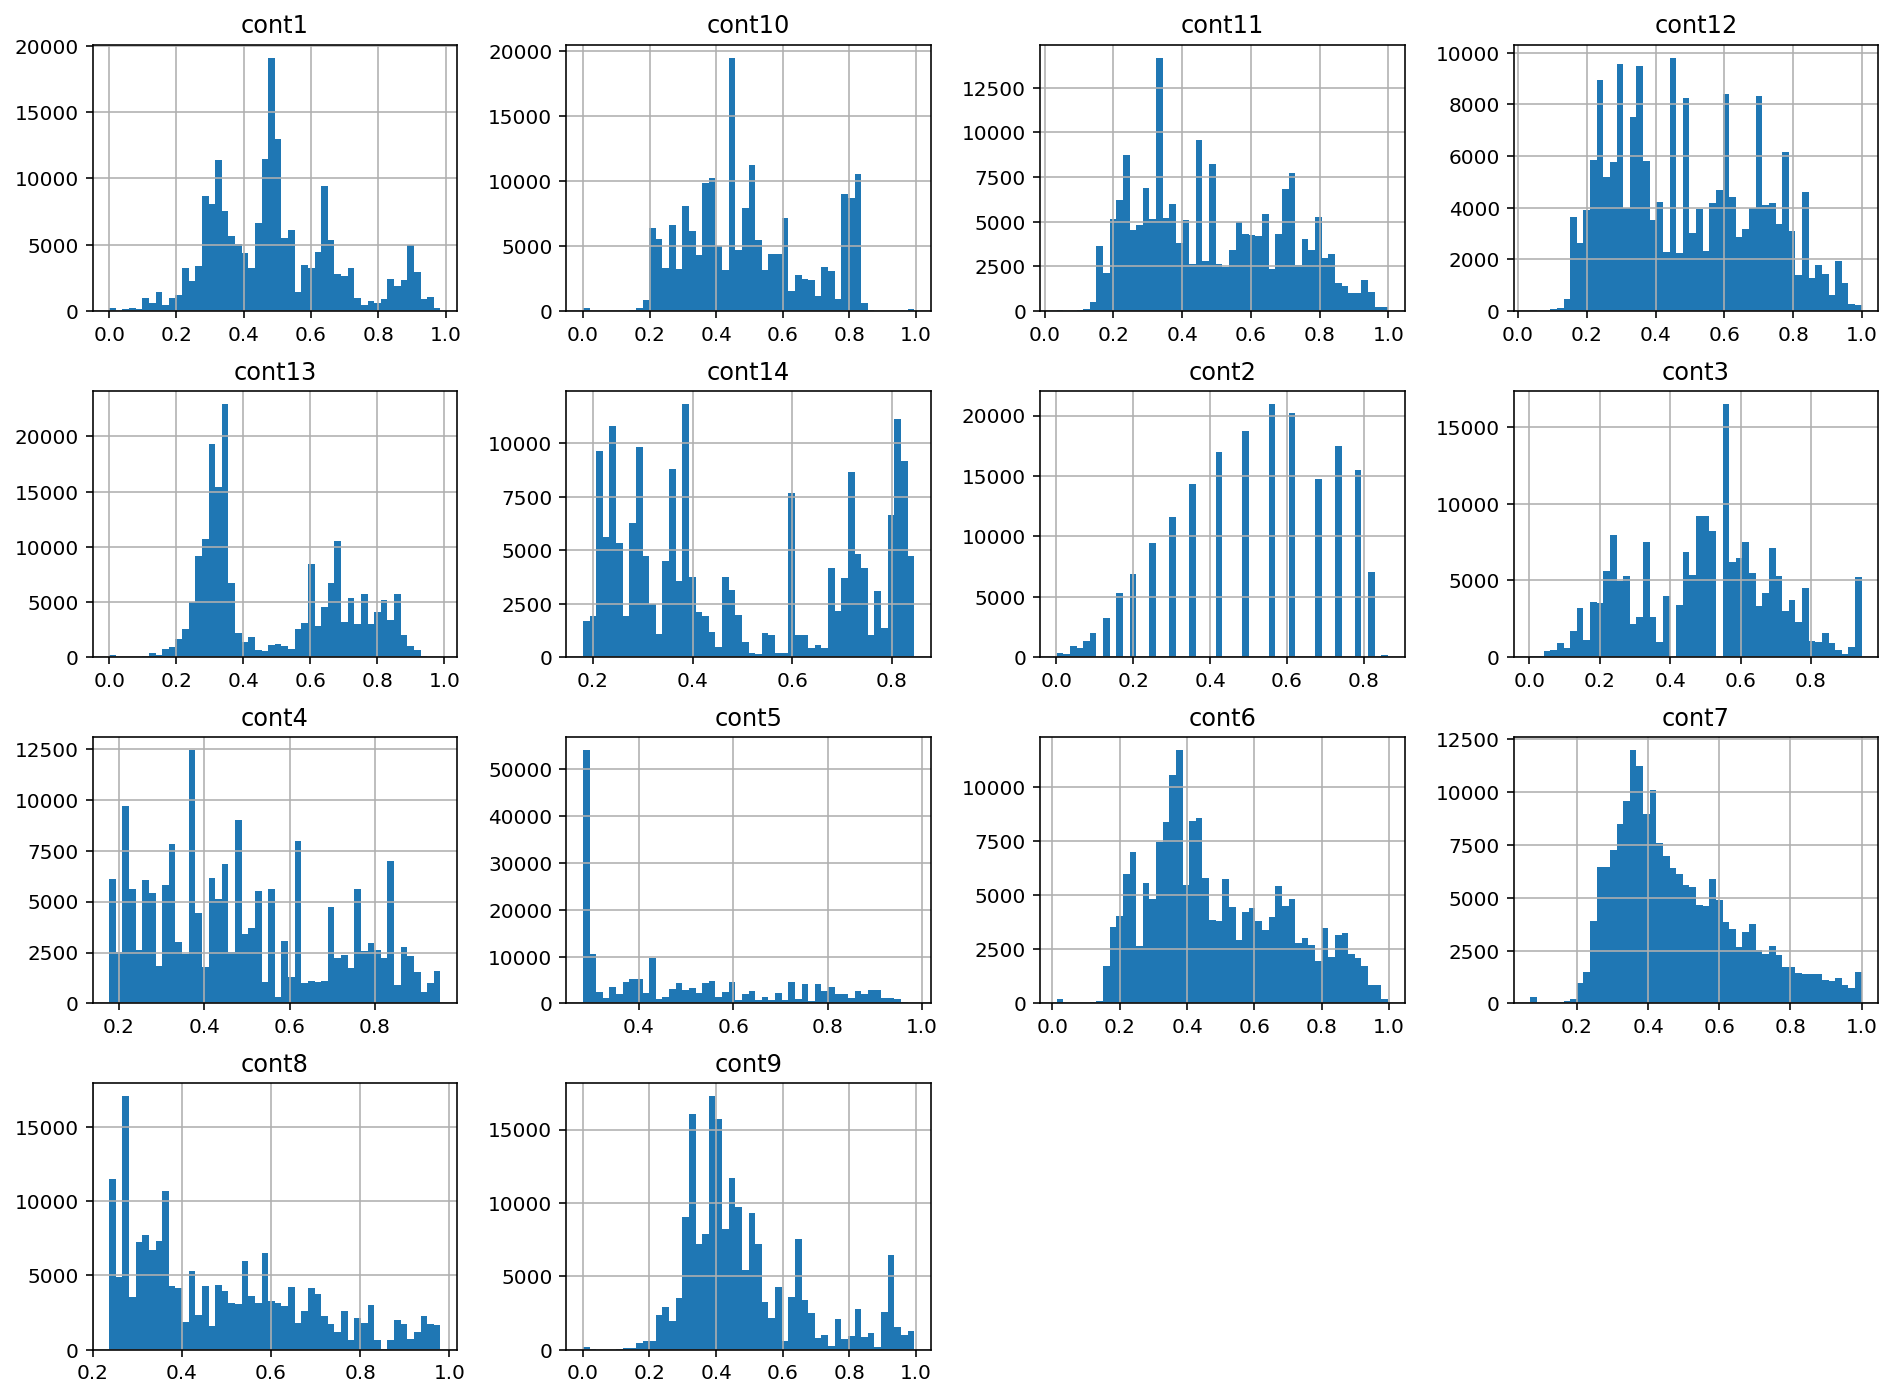

In [105]:
train[cont_features].hist(bins=50, figsize=(16,12))

### Feature Correlation (Pearson)

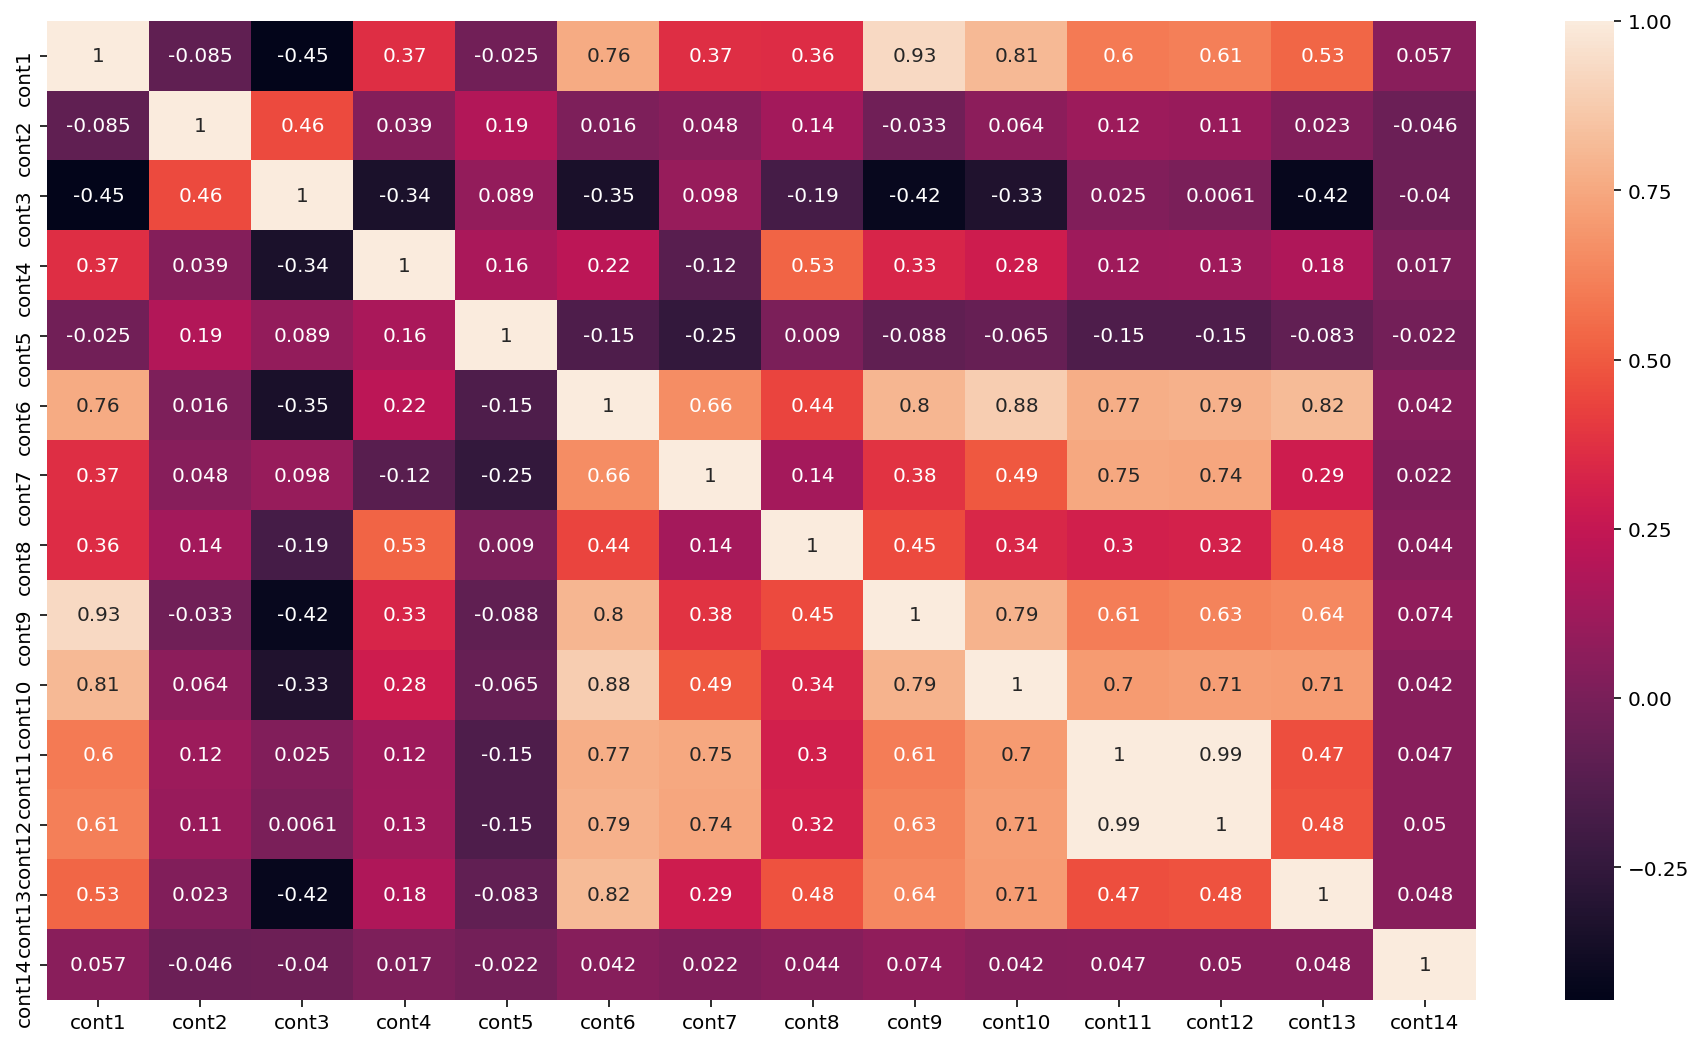

In [106]:
plt.subplots(figsize=(16,9))
correlation_mat = train[cont_features].corr()
sns.heatmap(correlation_mat, annot=True)

We can note from observation of the heatmap a concerning correlation between features! This suggests multicollinearity between features. There are many problems it causes, so we should be very careful while implementing linear regression models on current dataset.

## Test vs Train

The idea is to mix training and test sets and to see if a classifier (a logistic regression or a decision tree) can separate one from the other.

In [107]:
# Simple data preparation

train_d = train.drop(['id','loss'], axis=1)
test_d = test.drop(['id'], axis=1)

train_d['Target'] = 1
test_d['Target'] = 0

data = pd.concat((train_d, test_d))

# We use label encoding for categorical features:
data_le = copy.deepcopy(data)
for c in range(len(cat_features)):
    data_le[cat_features[c]] = data_le[cat_features[c]].astype('category').cat.codes

# We use one-hot encoding for categorical features:
data = pd.get_dummies(data=data, columns=cat_features)

Recreating training and test sets:

In [108]:
data = data.iloc[np.random.permutation(len(data))]
data.reset_index(drop = True, inplace = True)

x = data.drop(['Target'], axis = 1)
y = data.Target

train_examples = 100000

x_train = x[:train_examples]
x_test = x[train_examples:]
y_train = y[:train_examples]
y_test = y[train_examples:]

Now we train two classifiers: 1) logistic regression and 2) random forest — and use them to predict our test:

In [109]:
# Logistic Regression:
clf = LogisticRegression()
clf.fit(x_train, y_train)
pred = clf.predict_proba(x_test)[:,1]
auc = AUC(y_test, pred)
print("Logistic Regression AUC: {:.2%}".format(auc))

# Random Forest, (100 trees) trained in parallel
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
clf.fit(x_train, y_train)
pred = clf.predict_proba(x_test)[:,1]
auc = AUC(y_test, pred)
print("Random Forest AUC: {:.2%}".format(auc))

# (a 2-fold CV):
scores = cross_val_score(LogisticRegression(), x, y, scoring='roc_auc', cv=2)
print("Mean AUC: {:.2%}, std: {:.2%} \n".format( scores.mean(), scores.std()))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression AUC: 50.09%
Random Forest AUC: 49.92%


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Mean AUC: 50.16%, std: 0.04% 



## PCA

In [110]:
# Shuffle train and test
data_le = data_le.iloc[np.random.permutation(len(data_le))]

In [111]:
# And run PCA transformation
X = data_le.iloc[:, :130]
y = data_le.iloc[:, 130:]

pca = PCA(n_components=2)

X_reduced = pca.fit_transform(X)

ValueError: c of shape (313864, 1) not acceptable as a color sequence for x with size 313864, y with size 313864

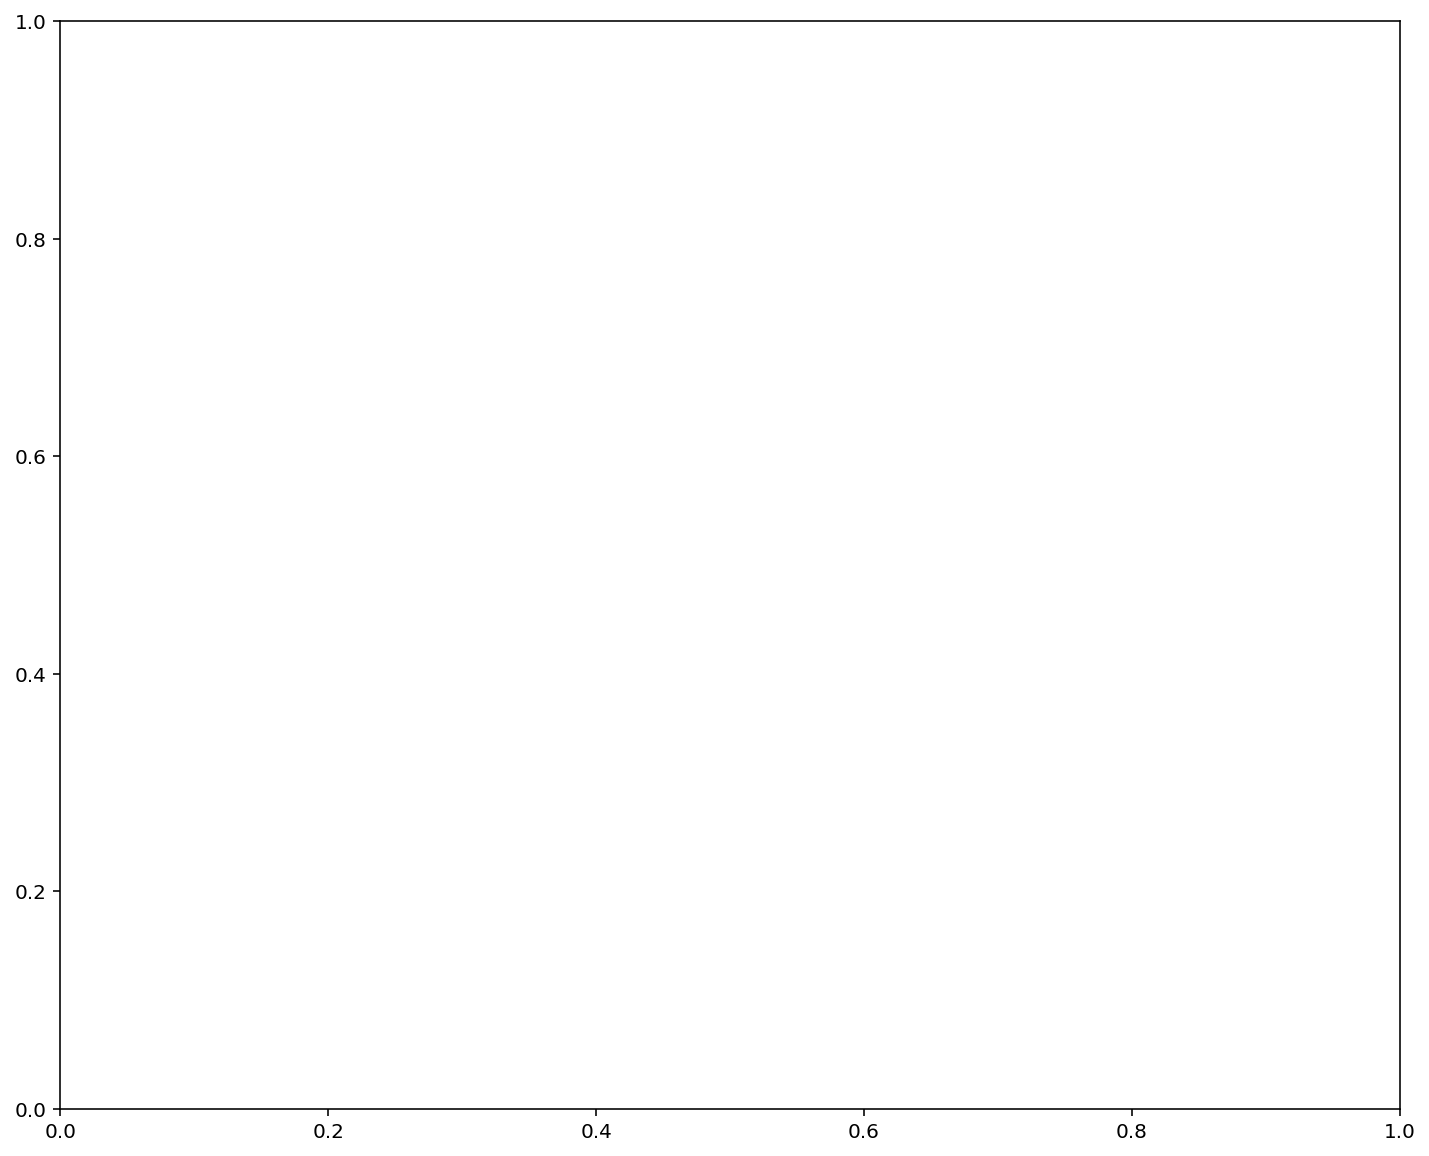

In [112]:
# Train = 1, Test = 0
plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=np.array(y), 
            edgecolor='none', s=40,
            cmap=plt.cm.get_cmap('winter', 2))
plt.title('PCA transformed train and test sets')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar()
plt.show()